In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

The data from the logs is pre-processed, combining the fund movement events (Supply, Withdraw, Borrow, Repay, FlashLoan) with the rate modification events in the contract (ReserveDataUpdated).

Again, the code is written once, but we iterate through the different networks and versions, changing the parameters that are necessary

## Merging DataFrames

In [2]:
# Excel file with all the AAVE pools to track
aavePools = pd.read_excel('aavePools.xlsx')
aavePools = aavePools.loc[:,['reserve', 'symbol', 'decimals', 'blockchain']].drop_duplicates()
aavePools.head(2)

,reserve,symbol,decimals,blockchain
0,0x5f98805a4e8be255a32880fdec7f6728c6568ba0,LUSD,18,ethereum
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,ethereum


In [24]:
# Open the AAVE Log Events gathered for every blockchain & version
df = pd.read_csv('aave-eth-V2.csv') # CHANGE HERE
print(df.shape)
df.head(2)

(47718, 8)


,transactionHash,blockNumber,liquidityRate,stableBorrowRate,variableBorrowRate,event,reserve,amount
0,0xe3e2122b8192bb482132e6022d458907d6bb00734707...,4477794,0,90000000000000000000000000,0,Supply,0x4200000000000000000000000000000000000006,1000000000000000
1,0x36686ea29a41133b05df534160e78f1dd7e31518b9ac...,4477805,1400000000000000000000400,90000000000000000000000000,15555555555555555555555556,Borrow,0x4200000000000000000000000000000000000006,100000000000000


In [25]:
# Merge DataFrames
df['reserve'] = df.reserve.str.lower()
df = df.merge(aavePools[aavePools.blockchain == 'ethereum']) # CHANGE HERE
print(df.shape)
df.head(2)

(47718, 11)


,transactionHash,blockNumber,liquidityRate,stableBorrowRate,variableBorrowRate,event,reserve,amount,symbol,decimals,blockchain
0,0xe3e2122b8192bb482132e6022d458907d6bb00734707...,4477794,0,90000000000000000000000000,0,Supply,0x4200000000000000000000000000000000000006,1000000000000000,WETH,18,optimism
1,0x36686ea29a41133b05df534160e78f1dd7e31518b9ac...,4477805,1400000000000000000000400,90000000000000000000000000,15555555555555555555555556,Borrow,0x4200000000000000000000000000000000000006,100000000000000,WETH,18,optimism


In [26]:
# Add Block Times
blockTimes = pd.read_csv('eth-blocks-11363052-16892651.csv') # CHANGE HERE
blockTimes['timestamp'] = pd.to_datetime(blockTimes['timestamp'])
df = df.merge(blockTimes, on = 'blockNumber', how = 'left')
df.head(2)

,transactionHash,blockNumber,liquidityRate,stableBorrowRate,variableBorrowRate,event,reserve,amount,symbol,decimals,blockchain,timestamp
0,0xe3e2122b8192bb482132e6022d458907d6bb00734707...,4477794,0,90000000000000000000000000,0,Supply,0x4200000000000000000000000000000000000006,1000000000000000,WETH,18,optimism,2022-03-15 21:48:20
1,0x36686ea29a41133b05df534160e78f1dd7e31518b9ac...,4477805,1400000000000000000000400,90000000000000000000000000,15555555555555555555555556,Borrow,0x4200000000000000000000000000000000000006,100000000000000,WETH,18,optimism,2022-03-15 21:48:44


## Calculate Metrics

In [28]:
# Transform numeric variables to the correct scales
RAY = 10**27
df['liquidityRate'] = ( df.liquidityRate.astype(float) / RAY ).astype(float)
df['stableBorrowRate'] = ( df.stableBorrowRate.astype(float) / RAY ).astype(float)
df['variableBorrowRate'] = ( df.variableBorrowRate.astype(float) / RAY ).astype(float)
df['amount'] = (df.amount).astype(float) / (10 ** df.decimals) 

# Reset txHash as Index & set timestamp as new index
df.set_index('timestamp', inplace=True)

df.head(2)

,transactionHash,blockNumber,liquidityRate,stableBorrowRate,variableBorrowRate,event,reserve,amount,symbol,decimals,blockchain
timestamp,,,,,,,,,,,
2022-03-15 21:48:20,0xe3e2122b8192bb482132e6022d458907d6bb00734707...,4477794,0.00,0.09,0.00,Supply,0x4200000000000000000000000000000000000006,0.00,WETH,18,optimism
2022-03-15 21:48:44,0x36686ea29a41133b05df534160e78f1dd7e31518b9ac...,4477805,0.00,0.09,0.02,Borrow,0x4200000000000000000000000000000000000006,0.00,WETH,18,optimism


________

Alternative for more than 1 MM rows:

In [ ]:
df.shape

In [15]:
# Transform numeric variables to the correct scales
RAY = 10**27
df['liquidityRate'] = (pd.concat([df.liquidityRate[:1000000].astype(float) / RAY, df.liquidityRate[1000000:].astype(float) / RAY])).astype(float)
df['stableBorrowRate'] = (pd.concat([df.stableBorrowRate[:1000000].astype(float) / RAY, df.stableBorrowRate[1000000:].astype(float) / RAY])).astype(float)
df['variableBorrowRate'] = (pd.concat([df.variableBorrowRate[:1000000].astype(float) / RAY, df.variableBorrowRate[1000000:].astype(float) / RAY])).astype(float)
df['amount'] = (df.amount).astype(float) / (10 ** df.decimals) 

# Reset txHash as Index & set timestamp as new index
df.set_index('timestamp', inplace=True)

df.head(2)

,transactionHash,blockNumber,liquidityRate,stableBorrowRate,variableBorrowRate,event,reserve,amount,symbol,decimals,blockchain
timestamp,,,,,,,,,,,
2020-11-30 23:11:50,0x3081a4ac6666e748fee8bc216b86c47c91c43dfd1172...,11363052,0.00,0.03,0.00,Deposit,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.00,WETH,18,ethereum
2020-11-30 23:13:23,0x6d18b83407c28345c8bb09f458b36cb4bbe0146e229d...,11363059,0.00,0.03,0.00,Deposit,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.00,WETH,18,ethereum


Polygon:

```
RAY = 10**27
df['liquidityRate'] = (pd.concat([df.liquidityRate[:1000000].astype(float) / RAY, df.liquidityRate[1000000:2000000].astype(float) / RAY,
                       df.liquidityRate[2000000:3000000].astype(float) / RAY, df.liquidityRate[3000000:4000000].astype(float) / RAY,
                       df.liquidityRate[4000000:].astype(float) / RAY])).astype(float)
df['stableBorrowRate'] = (pd.concat([df.stableBorrowRate[:1000000].astype(float) / RAY, df.stableBorrowRate[1000000:2000000].astype(float) / RAY,
                       df.stableBorrowRate[2000000:3000000].astype(float) / RAY, df.stableBorrowRate[3000000:4000000].astype(float) / RAY,
                       df.stableBorrowRate[4000000:].astype(float) / RAY])).astype(float)
df['variableBorrowRate'] = (pd.concat([df.variableBorrowRate[:1000000].astype(float) / RAY, df.variableBorrowRate[1000000:2000000].astype(float) / RAY,
                       df.variableBorrowRate[2000000:3000000].astype(float) / RAY, df.variableBorrowRate[3000000:4000000].astype(float) / RAY,
                       df.variableBorrowRate[4000000:].astype(float) / RAY])).astype(float)
df['amount'] = (df.amount).astype(float) / (10 ** df.decimals) 

# Reset txHash as Index & set timestamp as new index
df.set_index('timestamp', inplace=True)
```

______________

In case of processing AAVE V2 replace "Borrow" by "Supply" to avoid changing the following code

In [16]:
df["event"] = df["event"].replace("Deposit", "Supply")


In [17]:
df.event.unique()

array(['Supply', 'Withdraw', 'Borrow', 'Repay'], dtype=object)

___________________________

Calculate the aggregate and temporal metrics for each symbol.

Also, create a DF with timestamp every 5 minutes and the accumulated metrics, which we are going to use for training.

In [29]:
dfcum  = pd.DataFrame()
df10min = pd.DataFrame()

for symbol, group in df.groupby('symbol'):
    # Calculate cummulative net variables
    group['Supply'] = group['amount'].where(group['event']=='Supply', 0) # "Deposit" in V2
    group['Withdraw'] = group['amount'].where(group['event']=='Withdraw', 0)
    group['Borrow'] = group['amount'].where(group['event']=='Borrow', 0)
    group['Repay'] = group['amount'].where(group['event']=='Repay', 0)
                
    group['netSupplied'] = (group['amount'].where(group['event']=='Supply', 0).cumsum() - group['amount'].where(group['event']=='Withdraw', 0).cumsum())
    group['netBorrowed'] = (group['amount'].where(group['event']=='Borrow', 0).cumsum() - group['amount'].where(group['event']=='Repay', 0).cumsum())
    group['netLiquid'] = group['netSupplied'] - group['netBorrowed']
    dfcum = dfcum.append(group)

    # Resample the DataFrame in 5 minute intervals and compute agg functions
    df_resampled = group.resample('5T').agg({'blockchain': ['first'],
                                              'symbol': ['first'],
                                              'liquidityRate': ['mean', 'max', 'min'],
                                              'stableBorrowRate': ['mean', 'max', 'min'],
                                              'variableBorrowRate': ['mean', 'max', 'min'],
                                              'Supply': ['sum'],
                                              'Withdraw': ['sum'],
                                              'Borrow': ['sum'],
                                              'Repay': ['sum'],
                                              'netSupplied': ['last'],
                                              'netBorrowed': ['last'],
                                              'netLiquid': ['last'],
                                              })

    # rename the columns to match the requested names
    df_resampled.columns = ['blockchain', 'symbol', 'liquidityRateAvg', 'liquidityRateMax', 'liquidityRateMin', 
                            'stableBorrowRateAvg', 'stableBorrowRateMax', 'stableBorrowRateMin', 
                            'variableBorrowRateAvg', 'variableBorrowRateMax', 'variableBorrowRateMin',
                            'SupplySum', 'WithdrawSum', 'BorrowSum', 'RepaySum', 'netSupplied', 'netBorrowed', 'netLiquid']
    
    # Fill the corresponding columns with the previous value of the series
    df_resampled.iloc[:,:11] = df_resampled.iloc[:,:11].fillna(method='ffill')
    df_resampled.iloc[:,15:] = df_resampled.iloc[:,15:].fillna(method='ffill')

    # Fill the corresponding columns with 0
    df_resampled.iloc[:,11:15] = df_resampled.iloc[:,11:15].fillna(0)
    
    df10min = df10min.append(df_resampled)

print(dfcum.shape)
print(df10min.shape)
df10min.head(3)

(47718, 18)
(239677, 18)


,blockchain,symbol,liquidityRateAvg,liquidityRateMax,liquidityRateMin,stableBorrowRateAvg,stableBorrowRateMax,stableBorrowRateMin,variableBorrowRateAvg,variableBorrowRateMax,variableBorrowRateMin,SupplySum,WithdrawSum,BorrowSum,RepaySum,netSupplied,netBorrowed,netLiquid
timestamp,,,,,,,,,,,,,,,,,,
2022-04-23 01:30:00,optimism,AAVE,0.00,0.00,0.00,0.09,0.09,0.09,0.00,0.00,0.00,128.84,0.00,0.00,0.00,128.84,0.00,128.84
2022-04-23 01:35:00,optimism,AAVE,0.00,0.00,0.00,0.09,0.09,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,128.84,0.00,128.84
2022-04-23 01:40:00,optimism,AAVE,0.00,0.00,0.00,0.09,0.09,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,128.84,0.00,128.84


## Plot Check and Exploration

Exploring the liquidityRateAvg for the USDT series, we see that there are peaks generated by moments of extremely low liquidity, which we can ignore only for the case of this model.

<AxesSubplot:xlabel='timestamp'>

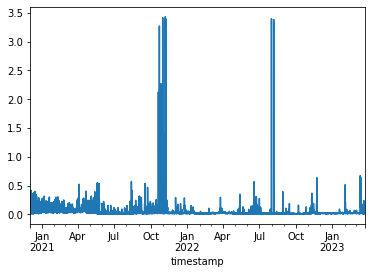

In [10]:
df10min[df10min.symbol == 'USDT'].liquidityRateAvg.plot()

<AxesSubplot:xlabel='timestamp'>

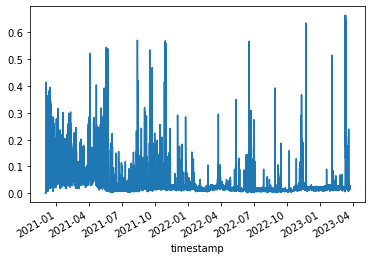

In [14]:
df10min[(df10min.symbol == 'USDT') & (df10min.liquidityRateAvg < 1)].liquidityRateAvg.plot()

If we look at it for a shorter period of time

<AxesSubplot:xlabel='timestamp'>

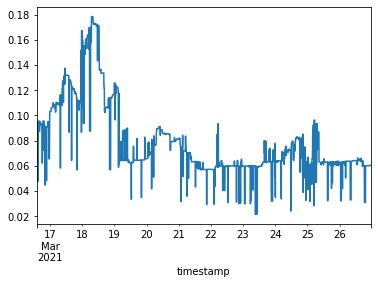

In [20]:
df10min[(df10min.symbol == 'USDT') & (df10min.liquidityRateAvg < 1)].liquidityRateAvg.iloc[30000:33000].plot()

In addition, as such a low temporality (5 min) for a low volume of movements can generate temporary peaks, it is more reasonable to predict the average rate in the next hour.

<AxesSubplot:xlabel='timestamp'>

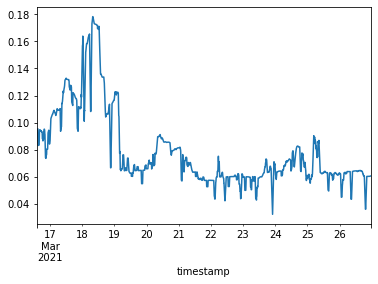

In [23]:
df10min[(df10min.symbol == 'USDT') & (df10min.liquidityRateAvg < 1)].liquidityRateAvg.iloc[30000:33000].rolling(window=12).mean().plot()

When we build the Target, we must also add a "shift" so that the average is future days and not past days already observed by the model

```
df10min[(df10min.symbol == 'USDT') & (df10min.liquidityRateAvg < 1)].liquidityRateAvg.shift(-12).rolling(window=12).mean().plot()
```

________________

# Dataset Constuction

### We are going to build the Training dataset to predict the "liquidityRate" (rate charged for providing liquidity) of the USDT token in the V2 protocol of ETH Mainet

Dates between March-21 and March-23 are considered to build the base

In [52]:
dataset = df10min[(df10min.symbol == 'USDT') & (df10min.index >= '2021-03-01') & (df10min.index <= '2023-03-01')]
dataset.shape

(210241, 18)

<AxesSubplot:xlabel='timestamp'>

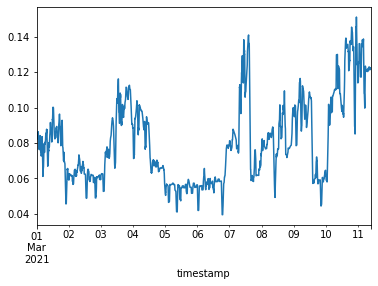

In [77]:
dataset[(dataset.liquidityRateAvg < 1)].iloc[:3000].liquidityRateAvg.shift(-12).rolling(window=12).mean().plot()

In [80]:
dataset['target'] = dataset[(dataset.liquidityRateAvg < 1)].liquidityRateAvg.shift(-12).rolling(window=12).mean()


C:\Users\Pablo\AppData\Local\Temp/ipykernel_8104/3850539294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset[(dataset.liquidityRateAvg < 1)].liquidityRateAvg.shift(-12).rolling(window=12).mean()


In [82]:
dataset.head(20)

,blockchain,symbol,liquidityRateAvg,liquidityRateMax,liquidityRateMin,stableBorrowRateAvg,stableBorrowRateMax,stableBorrowRateMin,variableBorrowRateAvg,variableBorrowRateMax,variableBorrowRateMin,SupplySum,WithdrawSum,BorrowSum,RepaySum,netSupplied,netBorrowed,netLiquid,target
timestamp,,,,,,,,,,,,,,,,,,,
2021-03-01 00:00:00,ethereum,USDT,0.08,0.08,0.08,0.16,0.16,0.16,0.11,0.11,0.11,0.00,0.00,200.00,0.00,144162934.30,35815895.62,108347038.68,NaN
2021-03-01 00:05:00,ethereum,USDT,0.08,0.08,0.08,0.16,0.16,0.16,0.11,0.11,0.11,0.00,0.00,0.00,0.00,144162934.30,35815895.62,108347038.68,NaN
2021-03-01 00:10:00,ethereum,USDT,0.09,0.10,0.08,0.20,0.27,0.16,0.15,0.22,0.11,0.00,353352.61,3000.00,0.00,143809581.70,35816632.90,107992948.79,NaN
2021-03-01 00:15:00,ethereum,USDT,0.09,0.10,0.08,0.20,0.27,0.16,0.15,0.22,0.11,0.00,0.00,0.00,0.00,143809581.70,35816632.90,107992948.79,NaN
2021-03-01 00:20:00,ethereum,USDT,0.09,0.10,0.08,0.19,0.25,0.17,0.14,0.20,0.12,0.00,153940.16,0.00,0.00,143655641.54,35816632.90,107839008.63,NaN
2021-03-01 00:25:00,ethereum,USDT,0.09,0.10,0.08,0.19,0.25,0.17,0.14,0.20,0.12,0.00,0.00,0.00,0.00,143655641.54,35816632.90,107839008.63,NaN
2021-03-01 00:30:00,ethereum,USDT,0.08,0.08,0.08,0.17,0.17,0.17,0.12,0.12,0.12,0.00,0.00,10000.00,0.00,143655641.54,35819090.50,107836551.03,NaN
2021-03-01 00:35:00,ethereum,USDT,0.08,0.08,0.08,0.17,0.17,0.17,0.12,0.12,0.12,0.00,0.00,0.00,0.00,143655641.54,35819090.50,107836551.03,NaN
2021-03-01 00:40:00,ethereum,USDT,0.02,0.09,0.00,0.07,0.20,0.00,0.04,0.15,0.00,0.00,0.00,2000000.00,0.00,143655641.54,36310610.50,107345031.03,NaN


In [83]:
dataset.to_csv('dataset-AAVE-ETH-V2-USDT.csv')

_____________________

## Other Feauters to help Predict the Target

#### From aave-ETH-v2

In [19]:
others = df10min[(df10min.symbol != 'USDT') & (df10min.index >= '2021-03-01') & (df10min.index <= '2023-03-01')]
others.head(2)

,blockchain,symbol,liquidityRateAvg,liquidityRateMax,liquidityRateMin,stableBorrowRateAvg,stableBorrowRateMax,stableBorrowRateMin,variableBorrowRateAvg,variableBorrowRateMax,variableBorrowRateMin,SupplySum,WithdrawSum,BorrowSum,RepaySum,netSupplied,netBorrowed,netLiquid
timestamp,,,,,,,,,,,,,,,,,,
2022-07-31 13:30:00,ethereum,1INCH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00,0.00,0.00,30.00,0.00,30.00
2022-07-31 13:35:00,ethereum,1INCH,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,30.00,0.00,30.00


In [20]:
others.symbol.unique()

array(['1INCH', 'AAVE', 'AMPL', 'BAL', 'BAT', 'BUSD', 'CRV', 'CVX', 'DAI',
       'DPI', 'ENJ', 'ENS', 'FEI', 'FRAX', 'GUSD', 'KNC', 'LINK', 'LUSD',
       'MANA', 'MKR', 'PAX', 'RAI', 'REN', 'RENFIL', 'SNX', 'TUSD', 'UNI',
       'USDC', 'UST', 'WBTC', 'WETH', 'YFI', 'ZRX', 'sUSD', 'stETH',
       'xSUSHI'], dtype=object)

In [21]:
aave_variables = pd.DataFrame()
aave_variables[['AAVEliquidityRate-ethV2','AAVEnetSupplied-ethV2','AAVEnetLiquid-ethV2']] = others.loc[(others.symbol == 'AAVE'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['CRVliquidityRate-ethV2','CRVnetSupplied-ethV2','CRVnetLiquid-ethV2']] = others.loc[(others.symbol == 'CRV'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['DAIliquidityRate-ethV2','DAInetSupplied-ethV2','DAInetLiquid-ethV2']] = others.loc[(others.symbol == 'DAI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['LINKliquidityRate-ethV2','LINKnetSupplied-ethV2','LINKnetLiquid-ethV2']] = others.loc[(others.symbol == 'LINK'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['UNIliquidityRate-ethV2','UNInetSupplied-ethV2','UNInetLiquid-ethV2']] = others.loc[(others.symbol == 'UNI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDCliquidityRate-ethV2','USDCnetSupplied-ethV2','USDCnetLiquid-ethV2']] = others.loc[(others.symbol == 'USDC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WBTCliquidityRate-ethV2','WBTCnetSupplied-ethV2','WBTCnetLiquid-ethV2']] = others.loc[(others.symbol == 'WBTC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WETHliquidityRate-ethV2','WETHnetSupplied-ethV2','WETHnetLiquid-ethV2']] = others.loc[(others.symbol == 'WETH'),['liquidityRateAvg','netSupplied','netLiquid']]

In [22]:
aave_variables.head(2)

,AAVEliquidityRate-ethV2,AAVEnetSupplied-ethV2,AAVEnetLiquid-ethV2,CRVliquidityRate-ethV2,CRVnetSupplied-ethV2,CRVnetLiquid-ethV2,DAIliquidityRate-ethV2,DAInetSupplied-ethV2,DAInetLiquid-ethV2,LINKliquidityRate-ethV2,LINKnetSupplied-ethV2,LINKnetLiquid-ethV2,UNIliquidityRate-ethV2,UNInetSupplied-ethV2,UNInetLiquid-ethV2,USDCliquidityRate-ethV2,USDCnetSupplied-ethV2,USDCnetLiquid-ethV2,WBTCliquidityRate-ethV2,WBTCnetSupplied-ethV2,WBTCnetLiquid-ethV2,WETHliquidityRate-ethV2,WETHnetSupplied-ethV2,WETHnetLiquid-ethV2
timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-01 00:00:00,0.00,2203141.44,2203141.49,0.02,8378491.36,5063972.45,0.09,84091573.81,-13276741.74,0.04,22330091.71,22144710.53,0.00,2453483.11,2449819.65,0.08,307705840.40,50591536.10,0.00,7010.50,6717.07,0.00,337181.25,306265.76
2021-03-01 00:05:00,0.00,2203141.44,2203141.49,0.02,8378491.36,5063972.45,0.07,83532765.40,-13835550.15,0.04,22330091.71,22144710.53,0.05,2460595.70,2456932.24,0.07,308105714.49,50990410.19,0.00,7010.50,6717.07,0.00,337181.25,306265.76


In [23]:
aave_variables.to_csv('dataset-AAVE-ETH-V2-others.csv')

________

#### From aave-ETH-v3

In [9]:
df10min.symbol.unique()

array(['AAVE', 'CRV', 'DAI', 'LINK', 'LUSD', 'USDC', 'USDT', 'WBTC',
       'WETH', 'cbETH', 'rETH', 'wstETH'], dtype=object)

In [10]:
aave_variables = pd.DataFrame()
aave_variables[['AAVEliquidityRateethV3','AAVEnetSuppliedethV3','AAVEnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'AAVE'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['CRVliquidityRateethV3','CRVnetSuppliedethV3','CRVnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'CRV'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['DAIliquidityRateethV3','DAInetSuppliedethV3','DAInetLiquidethV3']] = df10min.loc[(df10min.symbol == 'DAI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['LINKliquidityRateethV3','LINKnetSuppliedethV3','LINKnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'LINK'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDTliquidityRateethV3','USDTnetSuppliedethV3','USDTnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'USDT'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDCliquidityRateethV3','USDCnetSuppliedethV3','USDCnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'USDC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WBTCliquidityRateethV3','WBTCnetSuppliedethV3','WBTCnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'WBTC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WETHliquidityRateethV3','WETHnetSuppliedethV3','WETHnetLiquidethV3']] = df10min.loc[(df10min.symbol == 'WETH'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables.head(2)

,AAVEliquidityRateethV3,AAVEnetSuppliedethV3,AAVEnetLiquidethV3,CRVliquidityRateethV3,CRVnetSuppliedethV3,CRVnetLiquidethV3,DAIliquidityRateethV3,DAInetSuppliedethV3,DAInetLiquidethV3,LINKliquidityRateethV3,LINKnetSuppliedethV3,LINKnetLiquidethV3,USDTliquidityRateethV3,USDTnetSuppliedethV3,USDTnetLiquidethV3,USDCliquidityRateethV3,USDCnetSuppliedethV3,USDCnetLiquidethV3,WBTCliquidityRateethV3,WBTCnetSuppliedethV3,WBTCnetLiquidethV3,WETHliquidityRateethV3,WETHnetSuppliedethV3,WETHnetLiquidethV3
timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-27 14:30:00,0.00,0.00,0.00,NaN,NaN,NaN,0.71,171365.58,91.58,0.00,1.00,1.00,NaN,NaN,NaN,0.06,254883.54,69910.62,0.00,4.06,4.06,0.00,165.11,98.75
2023-01-27 14:35:00,0.00,0.00,0.00,NaN,NaN,NaN,0.71,171365.58,91.58,0.00,1.00,1.00,NaN,NaN,NaN,0.02,254883.54,72519.74,0.00,4.06,4.06,0.00,165.29,98.92


In [11]:
aave_variables.to_csv('dataset-AAVE-ETH-V3-others.csv')

___________________

#### From aave-Polygon-v3

In [9]:
df10min.symbol.unique()

array(['AAVE', 'BAL', 'CRV', 'DAI', 'DPI', 'EURS', 'GHST', 'LINK',
       'MaticX', 'SUSHI', 'USDC', 'USDT', 'WBTC', 'WETH', 'WMATIC',
       'agEUR', 'jEUR', 'miMATIC', 'stMATIC'], dtype=object)

In [10]:
aave_variables = pd.DataFrame()
aave_variables[['AAVEliquidityRateethPoly','AAVEnetSuppliedethPoly','AAVEnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'AAVE'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['CRVliquidityRateethPoly','CRVnetSuppliedethPoly','CRVnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'CRV'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['DAIliquidityRateethPoly','DAInetSuppliedethPoly','DAInetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'DAI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['LINKliquidityRateethPoly','LINKnetSuppliedethPoly','LINKnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'LINK'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDTliquidityRateethPoly','USDTnetSuppliedethPoly','USDTnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'USDT'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDCliquidityRateethPoly','USDCnetSuppliedethPoly','USDCnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'USDC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WBTCliquidityRateethPoly','WBTCnetSuppliedethPoly','WBTCnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'WBTC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WETHliquidityRateethPoly','WETHnetSuppliedethPoly','WETHnetLiquidethPoly']] = df10min.loc[(df10min.symbol == 'WETH'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables.head(2)

,AAVEliquidityRateethPoly,AAVEnetSuppliedethPoly,AAVEnetLiquidethPoly,CRVliquidityRateethPoly,CRVnetSuppliedethPoly,CRVnetLiquidethPoly,DAIliquidityRateethPoly,DAInetSuppliedethPoly,DAInetLiquidethPoly,LINKliquidityRateethPoly,LINKnetSuppliedethPoly,LINKnetLiquidethPoly,USDTliquidityRateethPoly,USDTnetSuppliedethPoly,USDTnetLiquidethPoly,USDCliquidityRateethPoly,USDCnetSuppliedethPoly,USDCnetLiquidethPoly,WBTCliquidityRateethPoly,WBTCnetSuppliedethPoly,WBTCnetLiquidethPoly,WETHliquidityRateethPoly,WETHnetSuppliedethPoly,WETHnetLiquidethPoly
timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-16 16:25:00,0.00,30.25,30.25,0.00,401.07,401.07,0.67,1.00,-2.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,7004.23,6998.23,0.00,0.00,0.00,0.00,2.20,2.20
2022-03-16 16:30:00,0.00,34.30,34.30,0.00,401.07,401.07,0.67,1.00,-2.00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,7004.23,6998.23,0.00,0.00,0.00,0.00,2.20,2.20


In [12]:
aave_variables.to_csv('dataset-AAVE-Polygon-V3-others.csv')

___________________

#### From aave-Avalanche-v3

In [19]:
df10min.symbol.unique()

array(['AAVE', 'BTC_b', 'DAI', 'FRAX', 'LINK', 'MAI', 'USDC', 'USDt',
       'WAVAX', 'WBTC', 'WETH', 'sAVAX'], dtype=object)

In [20]:
aave_variables = pd.DataFrame()
aave_variables[['AAVEliquidityRateethAvch','AAVEnetSuppliedethAvch','AAVEnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'AAVE'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['DAIliquidityRateethAvch','DAInetSuppliedethAvch','DAInetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'DAI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['LINKliquidityRateethAvch','LINKnetSuppliedethAvch','LINKnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'LINK'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDTliquidityRateethAvch','USDTnetSuppliedethAvch','USDTnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'USDt'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDCliquidityRateethAvch','USDCnetSuppliedethAvch','USDCnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'USDC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WBTCliquidityRateethAvch','WBTCnetSuppliedethAvch','WBTCnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'WBTC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WETHliquidityRateethAvch','WETHnetSuppliedethAvch','WETHnetLiquidethAvch']] = df10min.loc[(df10min.symbol == 'WETH'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables.head(2)

,AAVEliquidityRateethAvch,AAVEnetSuppliedethAvch,AAVEnetLiquidethAvch,DAIliquidityRateethAvch,DAInetSuppliedethAvch,DAInetLiquidethAvch,LINKliquidityRateethAvch,LINKnetSuppliedethAvch,LINKnetLiquidethAvch,USDTliquidityRateethAvch,USDTnetSuppliedethAvch,USDTnetLiquidethAvch,USDCliquidityRateethAvch,USDCnetSuppliedethAvch,USDCnetLiquidethAvch,WBTCliquidityRateethAvch,WBTCnetSuppliedethAvch,WBTCnetLiquidethAvch,WETHliquidityRateethAvch,WETHnetSuppliedethAvch,WETHnetLiquidethAvch
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-16 16:30:00,0.00,1.96,1.96,0.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.25,1.25
2022-03-16 16:35:00,0.00,1.96,1.96,0.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.25,1.25


In [21]:
aave_variables.to_csv('dataset-AAVE-Avalanche-V3-others.csv')

___________________

#### From aave-Optimism-v3

In [30]:
df10min.symbol.unique()

array(['AAVE', 'DAI', 'LINK', 'USDC', 'USDT', 'WBTC', 'WETH', 'sUSD'],
      dtype=object)

In [31]:
aave_variables = pd.DataFrame()
aave_variables[['AAVEliquidityRateethOp','AAVEnetSuppliedethOp','AAVEnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'AAVE'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['DAIliquidityRateethOp','DAInetSuppliedethOp','DAInetLiquidethOp']] = df10min.loc[(df10min.symbol == 'DAI'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['LINKliquidityRateethOp','LINKnetSuppliedethOp','LINKnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'LINK'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDTliquidityRateethOp','USDTnetSuppliedethOp','USDTnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'USDT'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['USDCliquidityRateethOp','USDCnetSuppliedethOp','USDCnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'USDC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WBTCliquidityRateethOp','WBTCnetSuppliedethOp','WBTCnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'WBTC'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables[['WETHliquidityRateethOp','WETHnetSuppliedethOp','WETHnetLiquidethOp']] = df10min.loc[(df10min.symbol == 'WETH'),['liquidityRateAvg','netSupplied','netLiquid']]
aave_variables.head(2)

,AAVEliquidityRateethAvch,AAVEnetSuppliedethAvch,AAVEnetLiquidethAvch,DAIliquidityRateethAvch,DAInetSuppliedethAvch,DAInetLiquidethAvch,LINKliquidityRateethAvch,LINKnetSuppliedethAvch,LINKnetLiquidethAvch,USDTliquidityRateethAvch,USDTnetSuppliedethAvch,USDTnetLiquidethAvch,USDCliquidityRateethAvch,USDCnetSuppliedethAvch,USDCnetLiquidethAvch,WBTCliquidityRateethAvch,WBTCnetSuppliedethAvch,WBTCnetLiquidethAvch,WETHliquidityRateethAvch,WETHnetSuppliedethAvch,WETHnetLiquidethAvch
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-04-23 01:30:00,0.00,128.84,128.84,0.00,303159.09,204698.29,0.00,17578.14,16625.19,0.01,373075.34,236241.09,0.00,1388323.59,1011302.18,0.00,12.22,11.85,0.00,1183.65,1142.55
2022-04-23 01:35:00,0.00,128.84,128.84,0.00,303159.09,204698.29,0.00,17578.14,16625.19,0.01,373075.34,236241.09,0.00,1388323.59,1011302.18,0.00,12.22,11.85,0.00,1183.65,1142.55


In [32]:
aave_variables.to_csv('dataset-AAVE-Optimism-V3-others.csv')